# 第一、数据处理与展示

In [5]:
import numpy as np

from utils import *
from model import *

# 加载数据
filename = 'dataset/dga_domains_full.csv'
file_dataframe = read_file(filename)
# 1表示DGA域名 0表示正常合法域名
file_dataframe.head()

,Domain,Label
0,cvyh1po636avyrsxebwbkn7,1
1,plasticbags,0
2,mzltrack,0
3,miss-slim,0
4,txumyqrubwutbb,1


# 第二、数据向量化与分割数据集

In [6]:
import nltk

# 数据向量化
list_Domain = file_dataframe['Domain'].tolist()
list_Label = file_dataframe['Label'].tolist()

# 返回数据矩阵，数据标签，最大单个域名长度，词字典
# data_vector, list_label, max_data_len, valid_chars = domain_to_vector(list_Domain, list_Label)


# 生成Bigram
Bigram_Data = []

for i in range(len(list_Domain)):
    var = []
    for j in range(len(list_Domain[i]) - 1):
        var.append(list_Domain[i][j] + list_Domain[i][j + 1])
    Bigram_Data.append(var)

Bigram_D = []

for i in range(len(list_Domain)):
    for j in range(len(list_Domain[i]) - 1):
        var = list_Domain[i][j] + list_Domain[i][j + 1]
        Bigram_D.append(var)

# 使用nltk统计bigram出现的次数

freq_dist_Data = nltk.FreqDist(Bigram_D)



# 用bigram出现的频率替换为数字
def data_to_vector(freq_dist, Bigram_list, list_Label):
    # 使用构造好的字典对域名进行处理
    list_data = [[freq_dist[y] for y in x] for x in Bigram_list]
    max_data_len = len(max(Bigram_list, key=len, default=''))
    # 以里面域名最大长度构造特征，小于最大长度的用一个非常小的值填充
    PAD_VALUE = 1e-10
    data_vector = sequence.pad_sequences(list_data, maxlen=max_data_len, dtype=np.float, value=PAD_VALUE)
    # 开平方根处理，使域名向量不会过大而导致无法输入神经网络，加60能够保留出现次数低的特征
    data_vector = np.sqrt(data_vector + 60) - np.sqrt(PAD_VALUE + 60)
    # 将标签列表转化为ndarray
    list_label = np.array(list_Label)
    return data_vector, list_label,max_data_len

data_vector, list_label, max_data_len = data_to_vector(freq_dist_Data, Bigram_Data, list_Label)
data_vector

array([[  0.        ,   0.        ,   0.        , ...,  65.34302017,
         71.63917046,  18.84350491],
       [  0.        ,   0.        ,   0.        , ..., 141.72309365,
        129.12623648,  81.58487904],
       [  0.        ,   0.        ,   0.        , ..., 202.81518832,
        166.32585756, 122.2578794 ],
       ...,
       [  0.        ,   0.        ,   0.        , ..., 157.00232617,
        137.15744942,  95.69483764],
       [  0.        ,   0.        ,   0.        , ..., 146.36113892,
         57.96552393,  54.99955108],
       [  0.        ,   0.        ,   0.        , ...,  86.2274338 ,
         80.62823769, 151.14393229]])

In [7]:
# 分割数据集
# 64开
split_size = 0.4 # 测试集占的比例
train_data, test_data, train_label, test_label = data_split(data_vector, list_label, split_size)

max_features = len(freq_dist_Data) + 1 # 数据集特征大小
print("数据集大小：{};".format(len(list_Domain)) + '最大域名长度：{};'.format(max_data_len) + "训练集大小：{};".format(len(train_data)) + "测试集大小：{};".format(len(test_data)))

# 计算合法域名和DGA域名
list_B = []
list_M = []
for i in range(len(list_Domain)):
    if list_Label[i] == 0:
        list_B.append(list_Domain[i])
    else:
        list_M.append(list_Domain[i])
print("合法域名大小：{};".format(len(list_B)) + "DGA域名大小：{};".format(len(list_M)))


BATCH_SIZE = 128
EPOCH = 20

数据集大小：674897;最大域名长度：62;训练集大小：404938;测试集大小：269959;
合法域名大小：337398;DGA域名大小：337499;


# 第三、CNN-At-LSTM模型的训练

In [8]:
import time


cnn_at_lstm_model = cnn_At_lstm(max_features, max_data_len)
# 训练数据集
start_time = time.time()
# 迭代20次，交叉验证集的比例为10%
history_cnn_at_lstm = cnn_at_lstm_model.fit(train_data, train_label, epochs=EPOCH, batch_size=BATCH_SIZE, shuffle=True, validation_split=0.1)
end_time = time.time()
print("花费时间为{}".format(end_time-start_time))
# 测试集的最终损失率, 准确律
loss_cnn_at_lstm ,tp, fp, tn, fn, accuracy_cnn_at_lstm, precision, recall, auc= cnn_at_lstm_model.evaluate(test_data, test_label, batch_size=BATCH_SIZE)
print('测试集最终损失值:', loss_cnn_at_lstm)
print('测试集准确率:', accuracy_cnn_at_lstm)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 62)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 62, 128)      179328      input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 62, 128)      32896       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 62, 128)      49280       embedding_1[0][0]                
____________________________________________________________________________________________

In [9]:
# 保存模型
# 以json的形式保存模型的架构
modelPath = "models/cnn_at_lstm_model.json"
model_save_json(cnn_at_lstm_model, modelPath)

# 保存训练时的参数
historyPath1 = "models/history_cnn_at_lstm.txt"
save_history(history_cnn_at_lstm, historyPath1)

模型的架构json文件保存完成！


# 第四、CNN_LSTM模型的训练

In [10]:
import time



cnn_lstm_model = cnn_lstm(max_features, max_data_len)
# 训练数据集
start_time = time.time()
# 迭代20次，交叉验证集的比例为10%
history_cnn_lstm = cnn_lstm_model.fit(train_data, train_label, epochs=EPOCH, batch_size=BATCH_SIZE, shuffle=True,validation_split=0.1)
end_time = time.time()
print("花费时间为{}".format(end_time - start_time))
# 测试集的最终损失率, 准确律
loss_cnn_lstm, tp, fp, tn, fn, accuracy_cnn_lstm, precision, recall, auc = cnn_lstm_model.evaluate(test_data,
                                                                                                   test_label,
                                                                                                   batch_size=BATCH_SIZE)
print('测试集最终损失值:', loss_cnn_lstm)
print('测试集准确率:', accuracy_cnn_lstm)
# 保存模型
# 以json的形式保存模型的架构
modelPath = "models/cnn_lstm_model.json"
model_save_json(cnn_lstm_model, modelPath)

# 保存训练时的参数
historyPath1 = "models/history_cnn_lstm.txt"
save_history(history_cnn_lstm, historyPath1)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 62)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 62, 128)      179328      input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 62, 128)      32896       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 62, 128)      49280       embedding_2[0][0]                
____________________________________________________________________________________________

# 第五、CNN模型的训练

In [11]:
# 训练cnn模型

cnn_model = cnn(max_features, max_data_len)

import time



# 训练数据集
start_time = time.time()
# 迭代20次，交叉验证集的比例为20%
history_cnn = cnn_model.fit(train_data, train_label, epochs=EPOCH, batch_size=BATCH_SIZE, shuffle=True, validation_split=0.1)
end_time = time.time()
print("花费时间为{}".format(end_time-start_time))
# 测试集的最终损失率, 准确律
loss_cnn ,tp, fp, tn, fn, accuracy_cnn, precision, recall, auc= cnn_model.evaluate(test_data, test_label, batch_size=BATCH_SIZE)
print('测试集最终损失值:', loss_cnn)
print('测试集准确率:', accuracy_cnn)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 62)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 62, 128)      179328      input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 62, 128)      32896       embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 62, 128)      49280       embedding_3[0][0]                
____________________________________________________________________________________________

In [12]:
# 保存模型
# 以json的形式保存模型的架构
modelPath = "models/cnn_model.json"
model_save_json(cnn_model, modelPath)
# 保存训练时的参数
historyPath2 = "models/history_cnn.txt"
save_history(history_cnn, historyPath2)

模型的架构json文件保存完成！


# 第七、LSTM模型的训练

In [13]:
# 训练lstm模型

lstm_model = lstm(max_features, max_data_len)

import time



# 训练数据集
start_time = time.time()
# 迭代20次，交叉验证集的比例为10%
history_lstm = lstm_model.fit(train_data, train_label, epochs=EPOCH, batch_size=BATCH_SIZE, shuffle=True, validation_split=0.1)
end_time = time.time()
print("花费时间为{}".format(end_time - start_time))
# 测试集的最终损失率, 准确律
loss_lstm ,tp, fp, tn, fn, accuracy_lstm, precision, recall, auc= lstm_model.evaluate(test_data, test_label, batch_size=BATCH_SIZE)
print('测试集最终损失值:', loss_lstm)
print('测试集准确率:', accuracy_lstm)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 62)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 62, 128)           179328    
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 311,041
Trainable params: 311,041
Non-trainable params: 0
_____________________________________________________

In [14]:
# 保存模型
# 以json的形式保存模型的架构
modelPath = "models/lstm_model.json"
model_save_json(cnn_lstm_model, modelPath)
# 保存训练时的参数
historyPath3 = "models/history_lstm.txt"
save_history(history_lstm, historyPath3)

模型的架构json文件保存完成！


# 第八、绘图

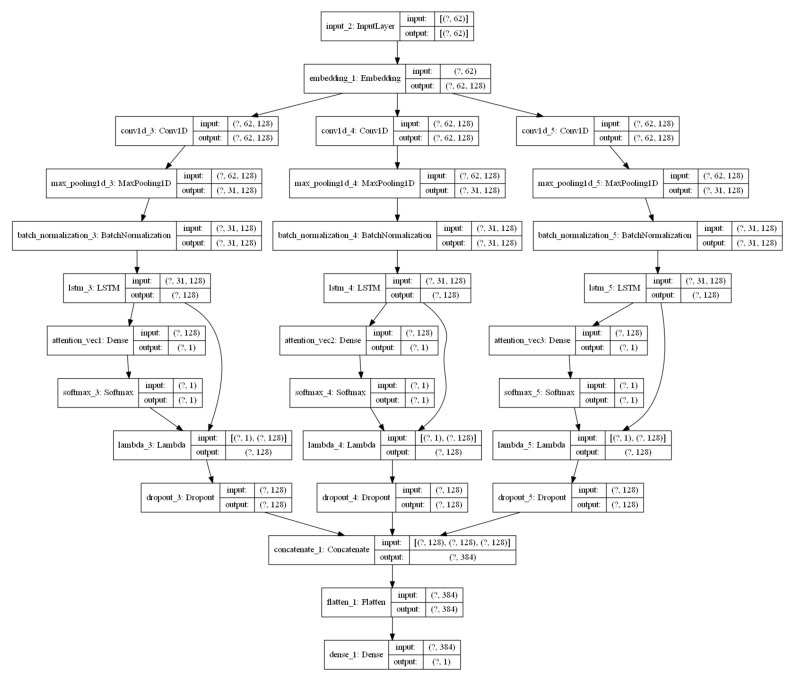

In [15]:
# 绘图
# 绘制cnn_at_lstm图像
plot_MyModel(cnn_at_lstm_model, 'result_img/cnn_at_lstm_model.png')

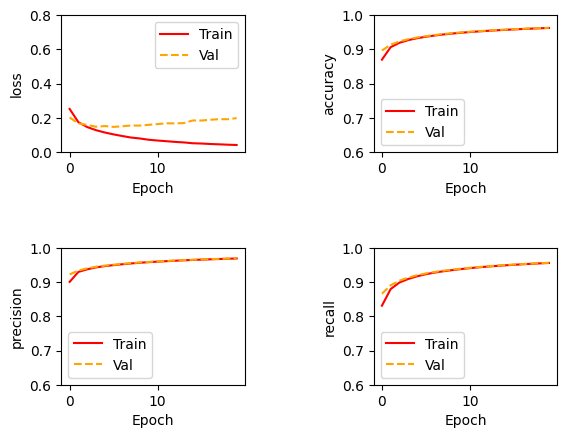

In [16]:
# 绘图accuracy, precision, recall, loss
plot_confusion_metrics(history_cnn_at_lstm, 'result_img/cnn_at_lstm_metric.png')

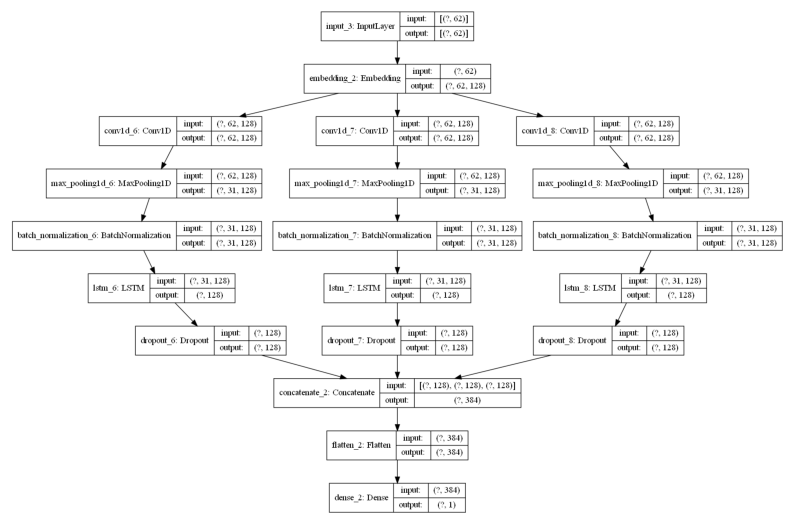

In [17]:
# 绘制cnn_lstm图像
plot_MyModel(cnn_lstm_model, 'result_img/cnn_lstm_model.png')

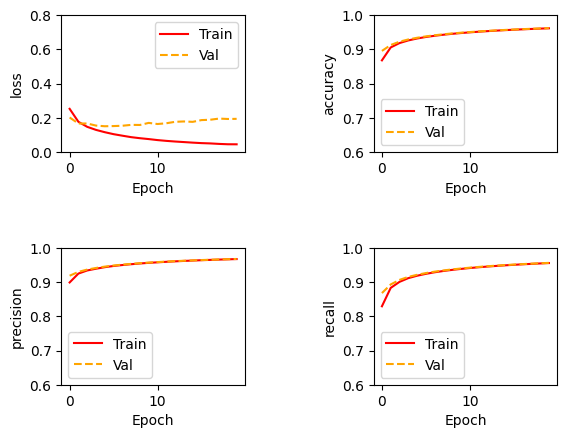

In [18]:
# 绘图accuracy, precision, recall, loss
plot_confusion_metrics(history_cnn_lstm, 'result_img/cnn_lstm_metric.png')

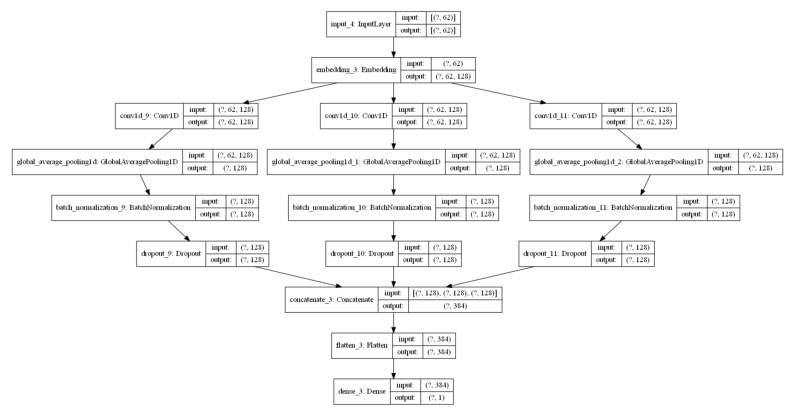

In [19]:
# 绘制cnn图像
plot_MyModel(cnn_model, 'result_img/cnn_model.png')

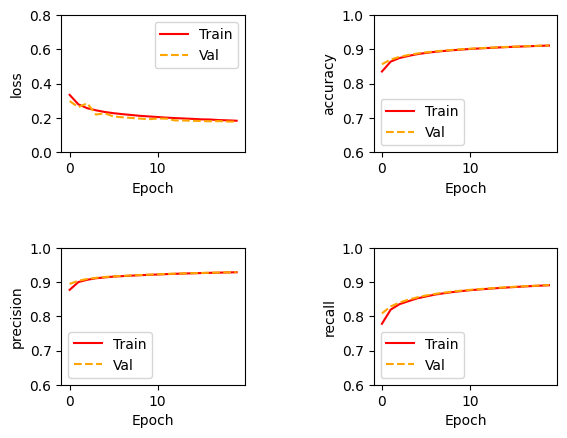

In [20]:
# 绘图accuracy, precision, recall, loss
plot_confusion_metrics(history_cnn, 'result_img/cnn_model_metric.png')

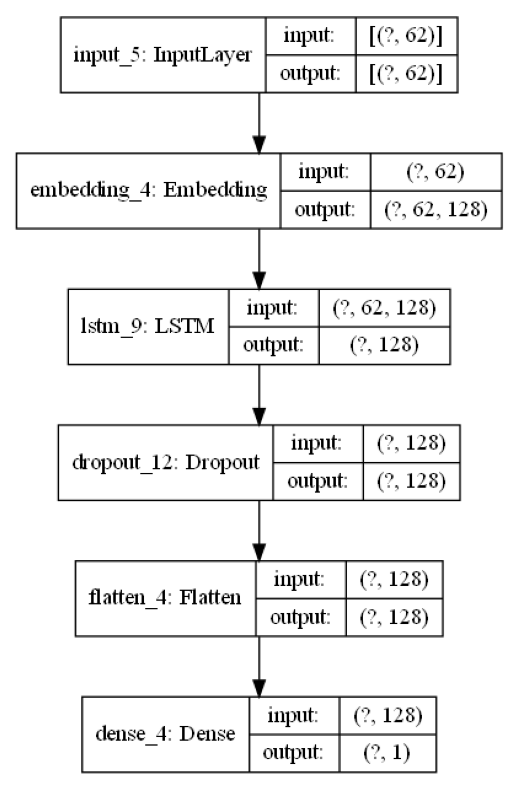

In [21]:
# 绘制lstm图像
plot_MyModel(lstm_model, 'result_img/lstm_model.png')

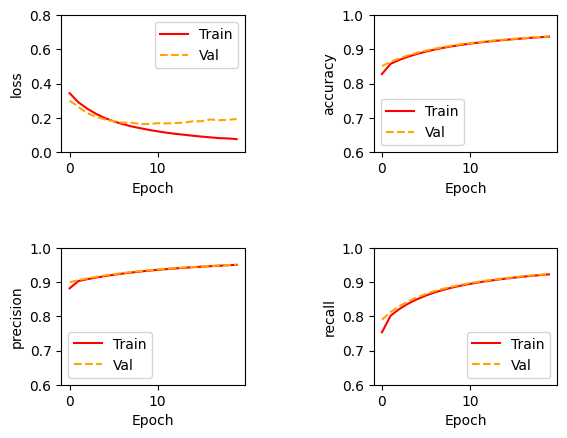

In [22]:
# 绘图accuracy, precision, recall, loss
plot_confusion_metrics(history_lstm, 'result_img/lstm_model_metric.png')

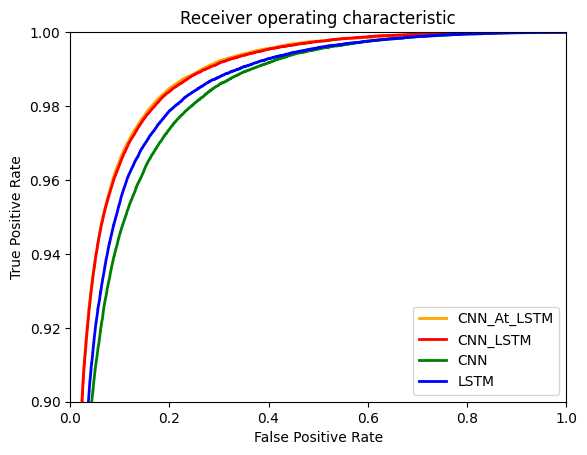

In [27]:
# 四个模型比较的ROC
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt


cnn_at_lstm_predictions = cnn_at_lstm_model.predict(test_data, batch_size=128)
cnn_lstm_predictions = cnn_lstm_model.predict(test_data, batch_size=128)
cnn_predictions = cnn_model.predict(test_data, batch_size=128)
lstm_predictions = lstm_model.predict(test_data, batch_size=128)


# 使用roc_curve函数计算ROC曲线数据
fpr_c_a_l, tpr_c_a_l, thresholds_c_a_l = roc_curve(test_label, cnn_at_lstm_predictions)
fpr_c_l, tpr_c_l, thresholds_c_l = roc_curve(test_label, cnn_lstm_predictions)
fpr_c, tpr_c, thresholds_c = roc_curve(test_label, cnn_predictions)
fpr_l, tpr_l, thresholds_l = roc_curve(test_label, lstm_predictions)




# 绘制ROC曲线
plt.figure()
lw = 2
plt.plot(fpr_c_a_l, tpr_c_a_l, color='orange', lw=lw, label="CNN_At_LSTM")
plt.plot(fpr_c_l, tpr_c_l, color='red', lw=lw, label="CNN_LSTM")
plt.plot(fpr_c, tpr_c, color='green', lw=lw, label="CNN")
plt.plot(fpr_l, tpr_l, color='blue', lw=lw, label="LSTM")


plt.xlim([0.0, 1.0])
plt.ylim([0.90, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
